In [8]:
from __future__ import print_function

import numpy as np
import warnings
import tensorflow

%env KERAS_BACKEND=tensorflow
from keras.callbacks import LearningRateScheduler
import keras
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs

env: KERAS_BACKEND=tensorflow


In [0]:
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer

In [0]:
def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer

In [0]:
def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out

In [0]:
def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model

In [13]:
from keras.datasets import cifar10


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mean_image = np.mean(x_train, axis=0)
x_train -= mean_image
x_test -= mean_image
x_train = x_train/128
x_test = x_test/128 
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [16]:

from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

batch_size = 128

nb_epoch = 200
data_augmentation = True
lr_schedule = [40,60,70] # epoch_step
def schedule(epoch_idx):
    if (epoch_idx + 1) < lr_schedule[0]:
        return 0.001 
    if (epoch_idx + 1) < lr_schedule[1]:
        return 0.0001
    if (epoch_idx + 1) < lr_schedule[2]:
        return 0.001
    return 0.0001
  
   
weight_decay = 1e-4
lr = 1e-1
num_classes = 10
resnet18 = ResNet18(input_shape=(32, 32, 3), classes=num_classes, weight_decay=weight_decay)
#opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
resnet18.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
resnet18.summary()




Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 32, 32, 64)   1728        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 32, 32, 64)   256         conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 32, 32, 64)   0           batch_normalization_41[0][0]     
_________________________________________________________________________________________

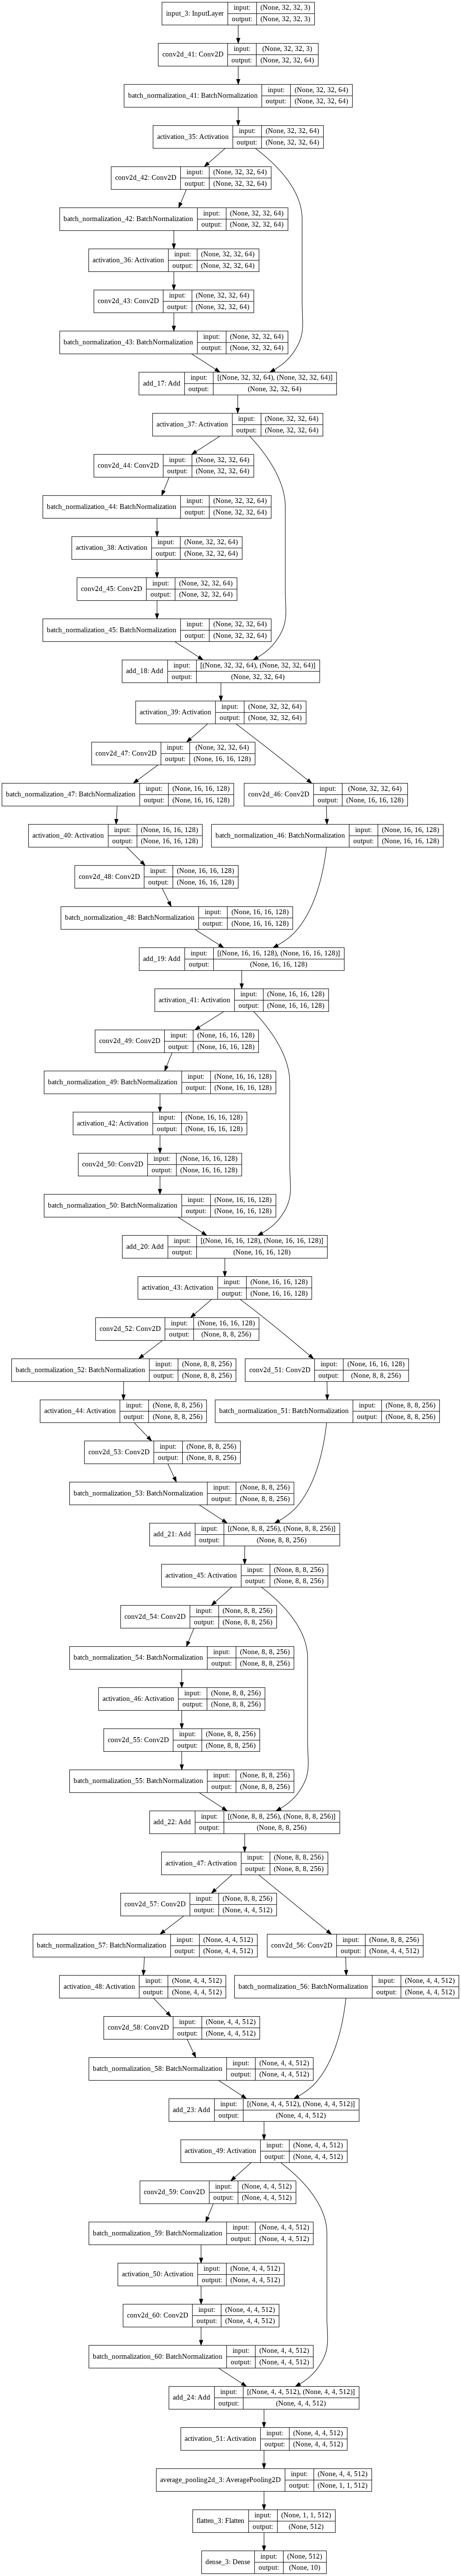

In [18]:
plot_model(resnet18, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [21]:
# Fit the model on the batches generated by datagen.flow().
history = resnet18.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test),
                    epochs=nb_epoch, verbose=1, max_q_size=100,
                    callbacks=[ LearningRateScheduler(schedule=schedule)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390, validation_data=(array([[[..., epochs=200, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`
  """




Epoch 1/200
390/390 [==============================] - 46s 119ms/step - loss: 1.7553 - acc: 0.5060 - val_loss: 3.4772 - val_acc: 0.3741
Epoch 2/200
390/390 [==============================] - 33s 84ms/step - loss: 1.1874 - acc: 0.6850 - val_loss: 1.8748 - val_acc: 0.5518
Epoch 3/200
390/390 [==============================] - 33s 84ms/step - loss: 0.9655 - acc: 0.7521 - val_loss: 1.8290 - val_acc: 0.5709
Epoch 4/200
390/390 [==============================] - 33s 84ms/step - loss: 0.8605 - acc: 0.7849 - val_loss: 1.3211 - val_acc: 0.6634
Epoch 5/200
390/390 [==============================] - 33s 84ms/step - loss: 0.7923 - acc: 0.8087 - val_loss: 0.8855 - val_acc: 0.7876
Epoch 6/200
390/390 [==============================] - 33s 84ms/step - loss: 0.7513 - acc: 0.8229 - val_loss: 1.3627 - val_acc: 0.6793
Epoch 7/200
390/390 [==============================] - 33s 84ms/step - loss: 0.7225 - acc: 0.8345 - val_loss: 1.0530 - val_acc: 0.7469
Epoch 8/200
390/390 [==============================]

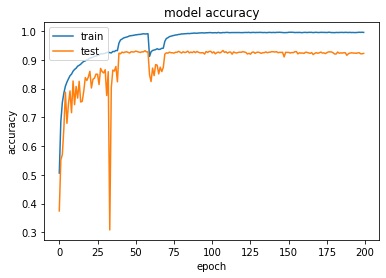

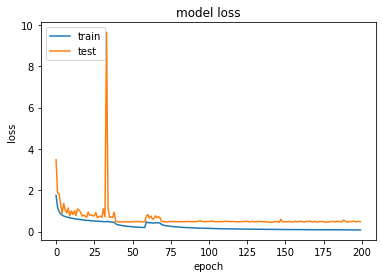

In [22]:

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
score = resnet18.evaluate(x_test,y_test,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Test loss: 0.4788119124174118
Test accuracy: 0.9228
